In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [2]:

folder_list = ['TE71ms', 'TE101ms', 'TE131ms', 'TE161ms', 'TE191ms']

Sqs   = np.zeros((96, 96, 54, 5, 5))        # to store the normalized signal data
Sb0   = np.zeros((96, 96, 54, 5))           # to store the unnormalized signal data to do masking
sigma_TE = np.zeros(5)                      # to store overall sigma per TE
sigma_va = np.zeros((96, 96, 54, 5, 5))     # to store sigma per voxel per acquisition

for m, folder in enumerate(folder_list):
    
    path_bval = f"/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/{folder}/Processed/dwi_bval.txt"
    path_nii  = f"/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/{folder}/Processed/dwi_eddy_unring.nii"

    img  = nib.load(path_nii)
    signal = np.flip(img.get_fdata(), axis = 0)

    bvals = np.loadtxt(path_bval) / 1000 # in unit ms/{\mu m} ^2

    Sb0[..., m] = np.mean(signal[:,:,:,bvals==0], axis=3)

    mask = bf.mask_brain(Sb0, median_radius = 1, numpass = 4, vol_idx = [m], least_size = 100, keep_top = 3)

    signal_normed = signal / np.repeat(Sb0[..., m:m+1], len(bvals), axis = -1)

    for i, b in enumerate(np.unique(bvals[bvals!=0])):
        Sqs[..., m, i] =  np.mean(signal_normed[..., bvals == b], axis = -1) 
        sigma_va[..., m, i] = np.std(signal_normed[..., bvals == b], axis = -1)

    sigma_TE[m] = np.std(signal_normed[..., bvals == 0][mask, :], mean = 1)     # notice! We know that the true mean is 1 


+-----------------------------------------------------------------------------+
Number of initial valid regions: 3
Sizes of each regions (1st is background): [400361  96848    306    149]
+-----------------------------------------------------------------------------+
Number of kept regions: 3
Sizes of kept regions: [96848   306   149]
+-----------------------------------------------------------------------------+
Number of initial valid regions: 3
Sizes of each regions (1st is background): [400078  97098    307    181]
+-----------------------------------------------------------------------------+
Number of kept regions: 3
Sizes of kept regions: [97098   307   181]
+-----------------------------------------------------------------------------+
Number of initial valid regions: 3
Sizes of each regions (1st is background): [399991  97103    371    199]
+-----------------------------------------------------------------------------+
Number of kept regions: 3
Sizes of kept regions: [97103   

In [3]:
print("sigma for each TE:               ", sigma_TE)
print("average sigma:                    ", np.mean(sigma_TE))
print("sigma for Sqs, \\bar{sigma}/sqrt(n)", np.mean(sigma_TE)/np.sqrt(30))

sigma for each TE:                [0.0289672  0.04144818 0.06253004 0.05671243 0.06993591]
average sigma:                     0.05191875143919368
sigma for Sqs, \bar{sigma}/sqrt(n) 0.009479023773583395


In [4]:
# reshape it to make it a 4D shape, the last dimension corresponds to qs. See below
Sqs = Sqs.reshape(Sqs.shape[0], Sqs.shape[1], Sqs.shape[2], 25, order = 'C') if Sqs.ndim == 5 else Sqs
sigma_va = sigma_va.reshape(sigma_va.shape[0], sigma_va.shape[1], sigma_va.shape[2], 25, order = 'C') if sigma_va.ndim == 5 else sigma_va

In [5]:
# No need to touch this. Just keep it assistant with the very beganning setting
qs, _ = bf.Cartesian(np.array([0.071, 0.101, 0.131, 0.161, 0.191]), np.array([0.7, 1.4, 2.1, 2.8, 3.5]))
qs = np.fliplr(qs)

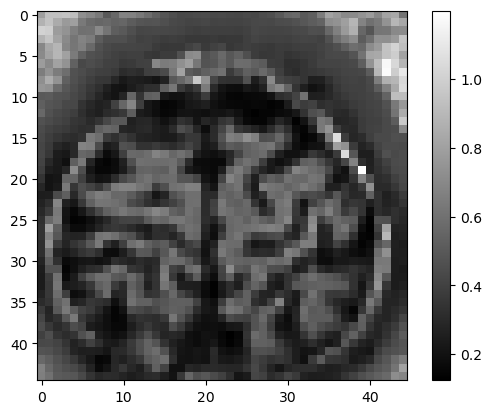

In [6]:
plt.imshow(np.fliplr(np.rot90(Sqs[25:70:, 25:70, 43, 5])), cmap = 'gray') 
plt.colorbar()
plt.show()

In [7]:
np.savez(   '/Users/xunan/Projects/MaxEnt/Data/Processed_Ning.npz', 
            Sb0 = Sb0,
            Sqs = Sqs, 
            qs = qs, 
            sigma_TE = sigma_TE/np.sqrt(30),        # Attention, devided by sqrt(30) because we are going to use the mean value Sqs
            sigma_va = sigma_va/np.sqrt(30)         # Attention, devided by sqrt(30) because we are going to use the mean value Sqs
        )

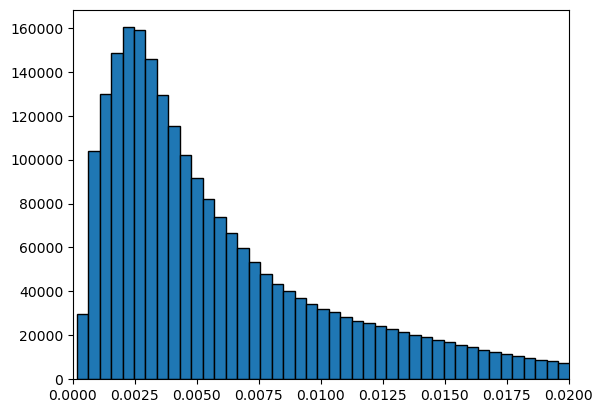

In [8]:
plt.hist(sigma_va[mask, :].ravel()/np.sqrt(30), bins = 500, edgecolor = 'black')
plt.xlim((0, 0.02))
plt.show()